# UniLEAF Experiment

Exported UniLEAF run.
Downloaded from previous run.

In [1]:
import numbers
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from abc import ABC
from abc import abstractmethod
from io import StringIO
from pandas.api.types import is_numeric_dtype
from typing import Any
from typing import Dict
from typing import List
from typing import Optional
from typing import Tuple
from typing import Type
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from leaf_common.candidates.representation_types import RepresentationType
from leaf_common.representation.rule_based.config.rule_set_config_helper import RuleSetConfigHelper
from leaf_common.representation.rule_based.data.features import Features
from leaf_common.representation.rule_based.data.rule_set import RuleSet
from leaf_common.representation.rule_based.data.rule_set_binding import RuleSetBinding
from leaf_common.representation.rule_based.evaluation.rule_set_binding_evaluator import RuleSetBindingEvaluator
from leaf_common.representation.rule_based.persistence.rule_set_file_persistence import RuleSetFilePersistence
from esp_sdk.esp_evaluator import EspEvaluator
from esp_sdk.esp_service import EspService
from unileaf_util.framework.interfaces.data_frame_predictor import DataFramePredictor
from unileaf_util.framework.metrics.metrics_manager import MetricsManager
from unileaf_util.framework.transformers.data_encoder import DataEncoder

pd.set_option('display.max_columns', None)

## Load the dataset

In [2]:
DATASET_CSV = "./processed_train.csv" # path to dataset CSV file
with open(DATASET_CSV) as df_file:
    data_source_df = pd.read_csv(df_file)
data_source_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
1,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
2,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
3,11,1.0,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
4,12,1.0,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [3]:
data_source_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,455.366120,0.672131,1.191257,35.674426,0.464481,0.475410,78.682469
std,247.052476,0.470725,0.515187,15.643866,0.644159,0.754617,76.347843
min,2.000000,0.000000,1.000000,0.920000,0.000000,0.000000,0.000000
25%,263.500000,0.000000,1.000000,24.000000,0.000000,0.000000,29.700000
50%,457.000000,1.000000,1.000000,36.000000,0.000000,0.000000,57.000000
75%,676.000000,1.000000,1.000000,47.500000,1.000000,1.000000,90.000000
max,890.000000,1.000000,3.000000,80.000000,3.000000,4.000000,512.329200


## Encode the dataset
Encode the dataset using the fields definition from the Experiment's data source

In [4]:
fields = {'Age': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 35.674427, 'range': [0.92, 80], 'std_dev': 15.643866, 'sum': 6528.42, 'valued': 'CONTINUOUS'}, 'Sex': {'data_type': 'STRING', 'has_nan': False, 'mean': 0, 'range': [0, 0], 'std_dev': 0, 'sum': 0, 'valued': 'CATEGORICAL', 'discrete_categorical_values': ['female', 'male']}, 'Fare': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 78.68247, 'range': [0, 512.3292], 'std_dev': 76.34784, 'sum': 14398.892, 'valued': 'CONTINUOUS'}, 'Parch': {'data_type': 'INT', 'has_nan': False, 'mean': 0.47540984, 'range': [0, 4], 'std_dev': 0.7546171, 'sum': 87, 'valued': 'CONTINUOUS'}, 'SibSp': {'data_type': 'INT', 'has_nan': False, 'mean': 0.46448088, 'range': [0, 3], 'std_dev': 0.64415854, 'sum': 85, 'valued': 'CONTINUOUS'}, 'Pclass': {'data_type': 'INT', 'has_nan': False, 'mean': 1.1912569, 'range': [1, 3], 'std_dev': 0.515187, 'sum': 218, 'valued': 'CONTINUOUS'}, 'Cabin_n': {'data_type': 'INT', 'has_nan': False, 'mean': 1.1639345, 'range': [1, 4], 'std_dev': 0.5193083, 'sum': 213, 'valued': 'CONTINUOUS'}, 'Cabin_r': {'data_type': 'STRING', 'has_nan': False, 'mean': 0, 'range': [0, 0], 'std_dev': 0, 'sum': 0, 'valued': 'CATEGORICAL', 'discrete_categorical_values': ['A', 'B', 'C', 'D', 'E', 'F', 'F G', 'G', 'T']}, 'Embarked': {'data_type': 'STRING', 'has_nan': False, 'mean': 0, 'range': [0, 0], 'std_dev': 0, 'sum': 0, 'valued': 'CATEGORICAL', 'discrete_categorical_values': ['C', 'Q', 'S']}, 'Survived': {'data_type': 'INT', 'has_nan': False, 'mean': 0.6721311, 'range': [0, 1], 'std_dev': 0.47072464, 'sum': 123, 'valued': 'CONTINUOUS'}}

In [5]:
import IPython.display
IPython.display.JSON(fields)

<IPython.core.display.JSON object>

In [6]:
cao_mapping = {'context': ['Age', 'Sex', 'Fare', 'Pclass'], 'actions': ['Parch', 'SibSp', 'Cabin_n', 'Cabin_r', 'Embarked'], 'outcomes': ['Survived']}

In [7]:
import IPython.display
IPython.display.JSON(cao_mapping)

<IPython.core.display.JSON object>

In [8]:
encoder = DataEncoder(fields, cao_mapping)
encoded_data_source_df = encoder.encode_as_df(data_source_df)
encoded_data_source_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,0.0,"[1.0, 0.0]",0.468892,0.333333,0.00,0.139136,"[1.0, 0.0, 0.0]"
1,1.0,0.0,"[1.0, 0.0]",0.430956,0.333333,0.00,0.103644,"[0.0, 0.0, 1.0]"
2,0.0,0.0,"[0.0, 1.0]",0.671219,0.000000,0.00,0.101229,"[0.0, 0.0, 1.0]"
3,1.0,1.0,"[1.0, 0.0]",0.038948,0.333333,0.25,0.032596,"[0.0, 0.0, 1.0]"
4,1.0,0.0,"[1.0, 0.0]",0.721801,0.000000,0.00,0.051822,"[0.0, 0.0, 1.0]"


## Predictor code

In [9]:
REGRESSOR = 'regressor'
CLASSIFIER = 'classifier'
TYPES = [REGRESSOR, CLASSIFIER]
predictors_by_id = {}

In [10]:
class PredictorType:
    """
    This class defines the type of Predictor Possible.
    """

    def __init__(self, predictor_type: str):
        """
        The constructor confirms if the type of predictor is supported.
        :param predictor_type: String describing a name for the type of the
        predictor.
        """
        assert predictor_type in TYPES, "Invalid Predictor Type"
        self.type = predictor_type

    def __str__(self) -> str:
        """
        This function overrides the string representation of the
        class.
        :return self.type: String
        """
        return self.type


In [11]:
class Predictor(DataFramePredictor, ABC):
    """
    This class contains the contract that any predictor
    must implement.
    """

    def __init__(self,
                 data_df: pd.DataFrame,
                 cao_mapping: Dict[str, List[str]],
                 data_split: Dict[str, float],
                 model_params: Dict = None,
                 metadata: Dict = None):
        """
        Initializes a predictor, its params and the metadata.
        :param data_df: DataFrame containing all processed data
        :param cao_mapping: a dictionary with `context`, `actions` and `outcomes`
        keys where each key returns a List of the selected column names as strings.
        :param data_split: Dictionary containing the training splits indexed
        by "train_pct" and "val_pct".
        :param model_params: Parameters of the model
        :param metadata: Dictionary describing any other information
        that must be stored along with the model.
        This might help in uniquely identifying the model
        :returns nothing
        """
        # Split the data between train, val and test sets
        self.data_split = data_split

        self.cao_mapping = cao_mapping
        self.context_actions_columns = self.cao_mapping["context"] + self.cao_mapping["actions"]
        # Check
        if len(cao_mapping["outcomes"]) > 1:
            if not self.does_support_multiobjective():
                raise ValueError(f"{self.predictor_name} does NOT support multiple outputs")

        self.column_length = {}
        if data_df is not None:
            train_df, val_df, test_df = self.generate_data_split(data_df, self.data_split)

            # Split the data between features (x) and labels(y)
            self.train_x_df, self.train_y_df = self.get_data_xy_split(train_df, cao_mapping)
            self.val_x_df, self.val_y_df = self.get_data_xy_split(val_df, cao_mapping)
            self.test_x_df, self.test_y_df = self.get_data_xy_split(test_df, cao_mapping)

            # Keep track of how many values are used to encode each outcome
            for column in self.cao_mapping["outcomes"]:
                first_value = self.train_y_df[column].head(1).values[0]
                if isinstance(first_value, numbers.Number):
                    # Value is a single scalar
                    self.column_length[column] = 1
                else:
                    # value is a one-hot encoded vector, i.e. a list. Get its size.
                    self.column_length[column] = len(self.train_y_df[column].head(1).values[0])
        else:
            # No data provided, assuming outcomes are numerical (not categorical)
            for column in self.cao_mapping["outcomes"]:
                self.column_length[column] = 1

        if model_params is None:
            model_params = {}
        self.model_params = model_params

        if metadata is None:
            metadata = {}
        self.metadata = metadata

        # Internal Parameters that are used to store the
        # latest state of the model.
        self._trained_model = None

    @property
    @abstractmethod
    def predictor_type(self) -> PredictorType:
        """
        :return the PredictorType of this Predictor: Regressor or Classifier
        """

    @property
    @abstractmethod
    def library(self) -> str:
        """
        :return the underlying library that implements this predictor, as a string
        """

    @property
    @abstractmethod
    def predictor_name(self) -> str:
        """
        :return: the name of the Predictor, as a string
        """

    @staticmethod
    @abstractmethod
    def does_support_multiobjective() -> bool:
        """
        This function returns if the predictor supports multiple outputs
        or not.
        :return multioutput: Bool
        """

    @abstractmethod
    def build_model(self, model_params: Dict):
        """
        This function must be overridden to build the model using the model
        parameters if desired and return a model.
        :param model_params: Dictionary containing the model parameters
        :return model: The built model.
        """

    @abstractmethod
    def train_model(self, model,
                    train_x: np.ndarray, train_y: np.ndarray,
                    val_x: Optional[np.ndarray], val_y: Optional[np.ndarray]) -> Type:
        """
        This function must be overridden to train the built model from the build_model step
        given the Data and must return the trained model.
        :param model: The model built in the build_model step
        :param train_x: numpy array containing the processed input features split for training
        :param train_y: numpy array containing the processed output features split for training
        :param val_x: Optional numpy array containing the processed input features split for validation
        :param val_y: Optional numpy array containing the processed output features split for validation

        :return trained_model
        """

    @staticmethod
    @abstractmethod
    def get_default_params() -> Dict:
        """
        This function should return the default Parameters of the model
        as Dictionary along with a description.
        :return default_model_params: Dictionary
        Format: {
            "parameter_name": {
                "default_value": "",
                "description": ""
            },
        }
        """

    def save_trained_model_state(self, trained_model) -> None:
        """
        This function stores the state of the trained model.
        :param trained_model: Trained model
        :return Nothing:
        """
        self._trained_model = trained_model

    def get_trained_model(self):
        """
        This function returns the trained model if it exists.
        :return self._trained_model:
        """
        if self._trained_model:
            return self._trained_model
        return None

    @staticmethod
    def generate_data_split(data_df: pd.DataFrame,
                            data_split: Dict[str, Any]) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], pd.DataFrame]:
        """
        Splits the data between train, validation (optional) and test sets
        :param data_df: the full dataset as a Pandas DataFrame
        :param data_split: a dictionary with the
        :return: a tuple of Pandas DataFrame: one for train, one for validation (or None), and one for test
        """

        # First, split the data set in train and test sets.
        # Use the provided random_state, if any
        random_state = data_split.get("random_state", None)
        shuffle = data_split.get("shuffle", True)
        train_df, test_df = train_test_split(data_df,
                                             test_size=data_split["test_pct"],
                                             random_state=random_state,
                                             shuffle=shuffle)

        # If we also need a validation set, split the train set into train and validation sets.
        val_pct = data_split.get("val_pct", 0)
        if val_pct > 0:
            train_df, val_df = train_test_split(train_df,
                                                test_size=val_pct,
                                                random_state=random_state,
                                                shuffle=shuffle)
        else:
            val_df = None
        return train_df, val_df, test_df

    def predict(self, encoded_context_actions_df: pd.DataFrame) -> pd.DataFrame:
        """
        This method uses the trained model to make a prediction for the passed Pandas DataFrame
        of context and actions. Returns the predicted outcomes in a Pandas DataFrame.
        :param encoded_context_actions_df: a Pandas DataFrame containing encoded rows of context and actions for
        which a prediction is requested. Categorical columns contain one-hot vectors, e.g. [1, 0, 0]. Which means
        a row can be a list of arrays (1 per column), e.g.: [1, 0, 0], [1,0].
        :return a Pandas DataFrame of the predicted outcomes for each context and actions row.
        """
        # Default implementation
        if self._trained_model:
            # Predict using the model's input columns, in case encoded_context_actions_df contains more columns
            # or is in a different order
            context_action_df = encoded_context_actions_df[self.context_actions_columns]
            # Convert one-hot vector columns into a single feature vector
            features = DataEncoder.encoded_df_to_np(context_action_df)
            predictions = self._trained_model.predict(features)
            if isinstance(predictions, pd.DataFrame):
                # Predictions are already in a DataFrame. Make sure they have the correct outcome names
                predictions_df = predictions
                predictions_df.columns = self.cao_mapping["outcomes"]
                # Convert predictions to float64 as it's JSON serializable, while float32 is not
                predictions_df = predictions_df.astype("float64")
            else:
                # Assuming predictions is a ndarray, convert it to a DataFrame with the output column names
                predictions_df = DataEncoder.np_to_encoded_df(predictions,
                                                              self.column_length)
        else:
            raise ValueError("Can't make predictions because the model has not been trained")
        return predictions_df

    @staticmethod
    def export_model(model_bytes: bytes, file_path: str):
        """
        Saves the model's bytes to the specified location
        :param model_bytes: the model bytes
        :param file_path: the name and path of the file to persist the bytes to
        :return: nothing
        """
        # Save the Model Locally
        with open(file_path, "wb") as my_file:
            my_file.write(model_bytes)

    @staticmethod
    def export_metrics(metrics_dict: Dict[str, Any], file_path: str):
        """
        Save the model's training metrics to the specified location
        :param metrics_dict: a dictionary containing metrics
        :param file_path: the name and path of the file to persist the bytes to
        :return: nothing
        """
        with open(file_path, 'w', encoding='utf-8') as my_file:
            json.dump(metrics_dict, my_file)

    @staticmethod
    def get_data_xy_split(data_df: Optional[pd.DataFrame],
                          cao_mapping: Dict) -> Tuple[Optional[pd.DataFrame], Optional[pd.DataFrame]]:
        """
        This function takes a dataframe and a dictionary mapping indices to context,
        action, or outcome. This then splits the dataframe into two dataframes based
        on it's CAO tagging.

        data_x: Context and Actions
        data_y: Outcomes

        :param data_df: a Pandas DataFrame with all the data
        :param cao_mapping: a dictionary with `context`, `actions` and `outcomes` keys where each key returns a List
         ofthe selected column names as strings.
        :return: A tuple containing two dataframes: data_x with the features, and data_y with the labels (outcomes)
        """
        if data_df is None:
            return None, None

        data_x_df = data_df[cao_mapping["context"] + cao_mapping["actions"]]
        data_y_df = data_df[cao_mapping["outcomes"]]

        return data_x_df, data_y_df

    def __str__(self):
        return self.predictor_name


In [12]:
class Regressor(PredictorType):
    """
    This class defines a Regressor Type
    """

    def __init__(self):
        """
        The constructor initializes the super class.
        """
        super().__init__(REGRESSOR)


In [13]:
class Classifier(PredictorType):
    """
    This class defines a Classifier Type
    """

    def __init__(self):
        """
        The constructor initializes the super class.
        """
        super().__init__(CLASSIFIER)


## Predictor 2627a716-23c3-3df7-ff1e-74af944ae7cf
### CAO columns

In [14]:
CONTEXT_COLUMNS = ['Age', 'Sex', 'Fare', 'Pclass']
ACTION_COLUMNS = ['Parch', 'SibSp', 'Embarked']
OUTCOME_COLUMNS = ['Survived']
CONTEXT_ACTION_COLUMNS = CONTEXT_COLUMNS + ACTION_COLUMNS

### Data split

In [15]:
data_split = {"train_pct": 0.8, "test_pct": 0.2}

### Predictor code

In [16]:
class RandomForestRegressorPredictor(Predictor):
    """
    This class implements a Random Forest regression model from the SKLearn library.
    """
    # Properties:
    predictor_type = Regressor()
    library = "sklearn"
    predictor_name = f"{library} Random Forest Regressor"

    def __init__(self,
                 data_df: pd.DataFrame,
                 cao_mapping: Dict[str, List[str]],
                 data_split: Dict = None,
                 model_params: Dict = None,
                 metadata: Dict = None):
        """
        The constructor initializes the base params.
        """
        super().__init__(data_df=data_df,
                         data_split=data_split,
                         model_params=model_params,
                         metadata=metadata,
                         cao_mapping=cao_mapping)

    @staticmethod
    def does_support_multiobjective() -> bool:
        """
        This function returns if the predictor supports multiple outputs
        or not.
        :return multioutput: Bool
        """
        multioutput = True
        return multioutput

    def build_model(self, model_params: Dict[str, Any]) -> RandomForestRegressor:
        """
        This function instantiates a RandomForestRegressor with the given params.
        :return model: a RandomForestRegressor instance
        """
        model = RandomForestRegressor(**model_params)
        return model

    def train_model(self, model: RandomForestRegressor,
                    train_x: np.ndarray, train_y: np.ndarray,
                    val_x: Optional[np.ndarray], val_y: Optional[np.ndarray]) -> RandomForestRegressor:
        """
        This function must be overridden to train the built model from the build_model step
        given the Data and must return the trained model and the desired metrics as a dictionary.
        :param model: The model built in the build_model step
        :param train_x: numpy array containing the processed input features split for training
        :param train_y: numpy array containing the processed output features split for training
        :param val_x: Optional numpy array containing the processed input features split for validation
        :param val_y: Optional numpy array containing the processed output features split for validation

        :return trained_model: The Random Forest model trained
        """
        if train_y.shape[1] == 1:
            # When there is only 1 label fit expects a 1d array.
            model.fit(train_x, train_y.ravel())
        else:
            model.fit(train_x, train_y)
        return model

    @staticmethod
    def get_default_params() -> Dict:
        """
        This function returns the default parameters along with a description.
        :return default_params: Default values with Description.
        """
        default_params = {
            "n_estimators": {
                "default_value": 100,
                "description": "The number of trees in the forest.",
                "type": "int"
            },
            "criterion": {
                "default_value": "mse",
                "description": "The function to measure the quality of a split. "
                               "Supported criteria are “mse” for the mean squared error, "
                               "which is equal to variance reduction as feature selection "
                               "criterion, and “mae” for the mean absolute error. Options: {'mse', 'mae'}",
                "type": ['mse', 'mae']
            },
            "max_depth": {
                "default_value": 100,
                "description": "The maximum depth of the tree. "
                               "If None, then nodes are expanded until all "
                               "leaves are pure or until all leaves contain less than "
                               "min_samples_split samples.",
                "type": "int"
            },
            "min_samples_split": {
                "default_value": 2,
                "description": "The minimum number of samples required to split an internal node.",
                "type": "float"
            },
            "min_samples_leaf": {
                "default_value": 1,
                "description": '''
                The minimum number of samples required to be at a leaf node.
                A split point at any depth will only be considered if it
                leaves at least min_samples_leaf training samples in each of the left and right branches.
                This may have the effect of smoothing the model, especially in regression.

                If int, then consider min_samples_leaf as the minimum number.
                If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples)
                are the minimum number of samples for each node.
                ''',
                "type": "float"
            },
            "min_weight_fraction_leaf": {
                "default_value": 0.0,
                "description": "The minimum weighted fraction of the sum total of"
                               " weights (of all the input samples) required to be at a leaf node. "
                               "Samples have equal weight when sample_weight is not provided.",
                "type": "float"
            },
            "max_features": {
                "default_value": "auto",
                "description": '''
                The number of features to consider when looking for the best split:

                If int, then consider max_features features at each split.
                If float, then max_features is a fraction and round(max_features * n_features) features are considered
                at each split.
                If “auto”, then max_features=n_features.
                If “sqrt”, then max_features=sqrt(n_features).
                If “log2”, then max_features=log2(n_features).
                If None, then max_features=n_features.
                Note: the search for a split does not stop until at least one valid partition of the node samples
                is found, even if it requires to effectively inspect more than max_features features.
                ''',
                "type": ["auto", "sqrt", "log2"]
            },
            "max_leaf_nodes": {
                "default_value": 100,
                "description": "Grow trees with max_leaf_nodes in best-first fashion. "
                               "Best nodes are defined as relative reduction in impurity. "
                               "If None then unlimited number of leaf nodes.",
                "type": "int"
            },
            "min_impurity_decrease": {
                "default_value": 0.0,
                "description": '''
                A node will be split if this split induces a decrease of the impurity greater than or equal
                to this value.

                The weighted impurity decrease equation is the following:

                N_t / N * (impurity - N_t_R / N_t * right_impurity
                                    - N_t_L / N_t * left_impurity)
                where N is the total number of samples, N_t is the number of samples at the current node,
                N_t_L is the number of samples in the left child, and N_t_R is the number of samples in the right child.

                N, N_t, N_t_R and N_t_L all refer to the weighted sum, if sample_weight is passed.
                ''',
                "type": "float"
            },
            "bootstrap": {
                "default_value": True,
                "description": "Whether bootstrap samples are used when building trees. "
                               "If False, the whole dataset is used to build each tree.",
                "type": "bool"
            },
            "oob_score": {
                "default_value": False,
                "description": "whether to use out-of-bag samples to estimate the R^2 on unseen data",
                "type": "bool"
            },
            "n_jobs": {
                "default_value": 1,
                "description": "The number of jobs to run in parallel. fit, predict, "
                               "decision_path and apply are all parallelized over the trees. "
                               "None means 1 unless in a joblib.parallel_backend context. "
                               "-1 means using all processors. See Glossary for more details.",
                "type": "int"
            },
            "random_state": {
                "default_value": 0,
                "description": "Controls both the randomness of the bootstrapping of the samples "
                               "used when building trees (if bootstrap=True) and the sampling of the "
                               "features to consider when looking for the best split at each "
                               "node (if max_features < n_features)",
                "type": "int"
            },
            "warm_start": {
                "default_value": False,
                "description": "When set to True, reuse the solution of the previous call to "
                               "fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.",
                "type": "bool"
            },
            "ccp_alpha": {
                "default_value": 0.0,
                "description": "Complexity parameter used for Minimal Cost-Complexity Pruning. "
                               "The subtree with the largest cost complexity that is smaller than "
                               "ccp_alpha will be chosen. By default, no pruning is performed. ",
                "type": "float"
            },
            "max_samples": {
                "default_value": 1,
                "description": '''
                If bootstrap is True, the number of samples to draw from X to train each base estimator.

                If None (default), then draw X.shape[0] samples.
                If int, then draw max_samples samples.
                If float, then draw max_samples * X.shape[0] samples.
                Thus, max_samples should be in the interval (0, 1).
                ''',
                "type": "float"
            }
        }

        return default_params


In [17]:
predictor_node_id = '2627a716-23c3-3df7-ff1e-74af944ae7cf'
predictor = RandomForestRegressorPredictor(encoded_data_source_df,
    cao_mapping={'context': ['Age', 'Sex', 'Fare', 'Pclass'], 'actions': ['Parch', 'SibSp', 'Embarked'], 'outcomes': ['Survived']},
data_split=data_split,
model_params={},
metadata={})

### Train Predictor

In [18]:
train_x = DataEncoder.encoded_df_to_np(predictor.train_x_df)
train_y = DataEncoder.encoded_df_to_np(predictor.train_y_df)
if predictor.val_x_df is not None:
    val_x = DataEncoder.encoded_df_to_np(predictor.val_x_df)
    val_y = DataEncoder.encoded_df_to_np(predictor.val_y_df)
else:
    val_x = None
    val_y = None

In [19]:
model = predictor.build_model(predictor.model_params)
trained_model = predictor.train_model(model,
                                      train_x, train_y,
                                      val_x, val_y)
predictor.save_trained_model_state(trained_model)
predictors_by_id[predictor_node_id] = predictor

### Predictor metrics

In [20]:
model_metrics = [MetricsManager.get_calculator('Mean Absolute Error')]
metrics = MetricsManager.compute_metrics(predictor,
model_metrics,predictor.train_x_df, predictor.train_y_df,predictor.val_x_df, predictor.val_y_df,predictor.test_x_df, predictor.test_y_df,encoder)

print(f'Predictor trained. Metrics: {metrics}')

Predictor trained. Metrics: {'train_Mean Absolute Error_Survived': 0.09623287671232876, 'test_Mean Absolute Error_Survived': 0.2897297297297297}


## Prescriptor
### ESP credentials

In [21]:
esp_username = os.getenv('ESP_SERVICE_USER')
esp_password = os.getenv('ESP_SERVICE_PASSWORD')
if not esp_username or not esp_password:
    print('Please set environment variables before proceeding.')
else:
    print('ESP Service username and password found.')

Please set environment variables before proceeding.


### Evaluation code

In [22]:
class UnileafPrescriptor(EspEvaluator):
    """
    An Unileaf Prescriptor makes prescriptions given an ESP candidate and a context DataFrame.
    It is also an EspEvaluator implementation that returns metrics for ESP candidates.
    """

    def __init__(self,
                 config: Dict[str, Any],
                 evaluation_df: pd.DataFrame,
                 data_encoder: DataEncoder,
                 predictors: List[Predictor]):
        """
        Constructs a prescriptor evaluator
        :param config: the ESP experiment config dictionary
        :param evaluation_df: the Pandas DataFrame to use to evaluate the candidates
        :param data_encoder: the DataEncoder used to encode the dataset
        :param predictors: the predictors this prescriptor relies on
        """
        # Instantiate EspEvaluator
        # Note: sets self.config
        super().__init__(config)

        # CAO
        self.cao_mapping = {"context": self.get_context_field_names(config),
                            "actions": self.get_action_field_names(config),
                            "outcomes": self.get_fitness_metrics(config)}
        self.context_df = evaluation_df[self.cao_mapping["context"]]
        self.row_index = self.context_df.index

        # Convert the context DataFrame to a format a NN can ingest
        self.context_as_nn_input = self.convert_to_nn_input(self.context_df)

        # Data encoder
        self.data_encoder = data_encoder

        # Predictors
        self.predictors = predictors

    @staticmethod
    def convert_to_nn_input(context_df: pd.DataFrame) -> List[np.ndarray]:
        """
        Converts a context DataFrame to a list of numpy arrays a neural network can ingest
        :param context_df: a DataFrame containing inputs for a neural network. Number of inputs and size must match
        :return: a list of numpy ndarray, on ndarray per neural network input
        """
        # The NN expects a list of i inputs by s samples (e.g. 9 x 299).
        # So convert the data frame to a numpy array (gives shape 299 x 9), transpose it (gives 9 x 299)
        # and convert to list(list of 9 arrays of 299)
        context_as_nn_input = list(context_df.to_numpy().transpose())
        # Convert each column's list of 1D array to a 2D array
        context_as_nn_input = [np.stack(context_as_nn_input[i], axis=0) for i in
                               range(len(context_as_nn_input))]
        return context_as_nn_input

    def evaluate_candidate(self, candidate):
        """
        Evaluates a single Prescriptor candidate and returns its metrics.
        Implements the EspEvaluator interface
        :param candidate: a Keras neural network or rule based Prescriptor candidate
        :return metrics: A dictionary of {'metric_name': metric_value}
        """
        # Prescribe actions
        prescribed_actions_df = self.prescribe(candidate)

        # Aggregate the context and actions dataframes.
        context_actions_df = pd.concat([self.context_df,
                                        prescribed_actions_df],
                                       axis=1)

        # Compute the metrics
        metrics = self._compute_metrics(context_actions_df)
        return metrics

    def _compute_metrics(self, context_actions_df):
        """
        Computes metrics from the passed context/actions DataFrame using the instance's trained predictors.
        :param context_actions_df: a DataFrame of context / prescribed actions
        :return: A dictionary of {'metric_name': metric_value}
        """
        # Get the predicted outcomes from the predictors
        metrics = {}
        for predictor in self.predictors:
            predicted_outcomes = predictor.predict(context_actions_df)

            # UN-853: Decode predictions before computing numerical metrics, if a data_encoder is available
            if self.data_encoder is not None:
                decoded_predicted_outcomes = self.data_encoder.decode_as_df(predicted_outcomes)
            else:
                decoded_predicted_outcomes = predicted_outcomes

            # Only add a metric for the outcomes the prescriptor is interested in
            for outcome in self.cao_mapping["outcomes"]:
                # Add the metrics that have been produced by this predictor
                if outcome in predictor.cao_mapping["outcomes"]:
                    # Check the type of metric: numerical or categorical?
                    if decoded_predicted_outcomes[[outcome]].iloc[:, 0].dtype == object:
                        # Categorical outcome. Use the *encoded* predicted outcome.
                        preds = predicted_outcomes[outcome]
                        # Classifiers return the category's index in the list of categories, so we can take the mean
                        # of the encoded outcomes. Note: this works because Outcomes are encoded using LabelEncoder
                        # AND the user defined order for each Outcome categories.
                        metrics[outcome] = preds.mean()
                    else:
                        # UN-853: Numerical outcome. Use the *decoded*, i.e. scaled back, predicted outcome
                        preds = decoded_predicted_outcomes[outcome]
                        # Regressors produce floats: take the mean of the decoded outcome
                        metrics[outcome] = preds.mean()
        return metrics

    def prescribe(self, candidate, context_df: pd.DataFrame = None) -> pd.DataFrame:
        """
        Generates prescriptions using the passed candidate and context
        :param candidate: an ESP candidate, either neural network or rules
        :param context_df: a DataFrame containing the context to prescribe for,
         or None to use the instance one
        :return: a DataFrame containing actions prescribed for each context
        """
        if context_df is None:
            # No context is provided, use the instance's one
            context_as_nn_input = self.context_as_nn_input
            row_index = self.row_index
        else:
            # Convert the context DataFrame to something more suitable for neural networks
            context_as_nn_input = self.convert_to_nn_input(context_df)
            # Use the context's row index
            row_index = context_df.index

        is_rule_based = isinstance(candidate, RuleSet)
        if is_rule_based:
            actions = self._prescribe_from_rules(candidate, context_as_nn_input)
        else:
            actions = self._prescribe_from_nn(candidate, context_as_nn_input)

        # Convert the prescribed actions to a DataFrame
        prescribed_actions_df = pd.DataFrame(actions,
                                             columns=self.cao_mapping["actions"],
                                             index=row_index)
        return prescribed_actions_df

    def _prescribe_from_rules(self, candidate, context_as_nn_input: List[np.ndarray]):
        """
        Generates prescriptions using the passed rules model candidate and context
        :param candidate: a rules model candidate
        :param context_as_nn_input: a numpy array containing the context to prescribe for
        :return: a dictionary of action name to list of action values
        """
        cand_states = RuleSetConfigHelper.get_states(self.config)
        cand_actions = RuleSetConfigHelper.get_actions(self.config)
        candidate = RuleSetBinding(candidate, cand_states, cand_actions)
        rules_encoder = RulesDataEncoder(candidate.actions)
        evaluator = RuleSetBindingEvaluator()
        rules_input = rules_encoder.encode_to_rules_data(context_as_nn_input)
        rules_output = evaluator.evaluate(candidate, rules_input)
        actions = rules_encoder.decode_from_rules_data(rules_output)
        return actions

    def _prescribe_from_nn(self, candidate, context_as_nn_input: List[np.ndarray]) -> Dict[str, Any]:
        """
        Generates prescriptions using the passed neural network candidate and context
        :param candidate: a Keras neural network candidate
        :param context_as_nn_input: a numpy array containing the context to prescribe for
        :return: a dictionary of action name to action value or list of action values
        """
        # Get the prescribed actions
        prescribed_actions = candidate.predict(context_as_nn_input)
        actions = {}

        if self._is_single_action_prescriptor():
            # Put the single action in an array to process it like multiple actions
            prescribed_actions = [prescribed_actions]

        for i, action_col in enumerate(self.cao_mapping["actions"]):
            if self._is_scalar(prescribed_actions[i]):
                # We have a single row and this action is numerical. Convert it to a scalar.
                actions[action_col] = prescribed_actions[i].item()
            else:
                actions[action_col] = prescribed_actions[i].tolist()
        return actions

    def _is_single_action_prescriptor(self):
        """
        Checks how many Actions have been defined in the Context, Actions, Outcomes mapping.
        :return: True if only 1 action is defined, False otherwise
        """
        return len(self.cao_mapping["actions"]) == 1

    @staticmethod
    def _is_scalar(prescribed_action):
        """
        Checks if the prescribed action contains a single value, i.e. a scalar, or an array.
        A prescribed action contains a single value if it has been prescribed for a single context sample
        :param prescribed_action: a scalar or an array
        :return: True if the prescribed action contains a scalar, False otherwise.
        """
        return prescribed_action.shape[0] == 1 and prescribed_action.shape[1] == 1

    @staticmethod
    def get_context_field_names(config: Dict[str, Any]) -> List[str]:
        """
        Returns the list of Context column names
        :param config: the ESP experiment config dictionary
        :return: the list of Context column names
        """
        nn_inputs = config["network"]["inputs"]
        contexts = [nn_input["name"] for nn_input in nn_inputs]
        return contexts

    @staticmethod
    def get_action_field_names(config: Dict[str, Any]) -> List[str]:
        """
        Returns the list of Action column names
        :param config: the ESP experiment config dictionary
        :return: the list of Action column names
        """
        nn_outputs = config["network"]["outputs"]
        actions = [nn_output["name"] for nn_output in nn_outputs]
        return actions

    @staticmethod
    def get_fitness_metrics(config: Dict[str, Any]) -> List[str]:
        """
        Returns the list of fitness metric names (Outcomes) to optimize.
        :param config: the ESP experiment config dictionary
        :return: the list of fitness metric names
        """
        metrics = config["evolution"]["fitness"]
        fitness_metrics = [metric["metric_name"] for metric in metrics]
        return fitness_metrics


### Prescriptor training

In [23]:
config = {'evolution': {'fitness': [{'maximize': True, 'metric_name': 'Survived'}], 'nb_elites': 5, 'mutation_type': 'gaussian_noise_percentage', 'nb_generations': 40, 'mutation_factor': 0.1, 'population_size': 10, 'parent_selection': 'tournament', 'initialization_range': 1, 'mutation_probability': 0.1, 'remove_population_pct': 0.8, 'initialization_distribution': 'orthogonal'}, 'network': {'inputs': [{'name': 'Age', 'size': 1, 'values': ['float']}, {'name': 'Sex', 'size': 2, 'values': ['female', 'male']}, {'name': 'Fare', 'size': 1, 'values': ['float']}, {'name': 'Pclass', 'size': 1, 'values': ['float']}], 'outputs': [{'name': 'Parch', 'size': 1, 'activation': 'sigmoid', 'use_bias': True, 'values': ['float']}, {'name': 'SibSp', 'size': 1, 'activation': 'sigmoid', 'use_bias': True, 'values': ['float']}, {'name': 'Cabin_n', 'size': 1, 'activation': 'sigmoid', 'use_bias': True, 'values': ['float']}, {'name': 'Cabin_r', 'size': 9, 'activation': 'softmax', 'use_bias': True, 'values': ['A', 'B', 'C', 'D', 'E', 'F', 'F G', 'G', 'T']}, {'name': 'Embarked', 'size': 3, 'activation': 'softmax', 'use_bias': True, 'values': ['C', 'Q', 'S']}], 'hidden_layers': [{'layer_name': 'hidden_1', 'layer_type': 'Dense', 'layer_params': {'units': 16, 'use_bias': True, 'activation': 'tanh'}}]}, 'LEAF': {'representation': 'NNWeights', 'experiment_id': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'version': '1.0.0', 'persistence_dir': 'trained_prescriptors/', 'candidates_to_persist': 'best'}}

In [24]:
import IPython.display
IPython.display.JSON(config)

<IPython.core.display.JSON object>

In [25]:
required_predictor_ids = ['2627a716-23c3-3df7-ff1e-74af944ae7cf']
all_predictors = [predictors_by_id[required_id] for required_id in required_predictor_ids]

In [26]:
# Instantiate the EspService
esp_service = EspService(config, esp_username, esp_password)
esp_evaluator = UnileafPrescriptor(config,
                                   encoded_data_source_df,
                                   encoder,
                                   all_predictors)
experiment_results_dir = esp_service.train(esp_evaluator)

Starting training:
  experiment_id: UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d
  checkpoint_id: None
  timestamp: 20251027-131022
Asking ESP for a seed generation...
Seed generation received.
Evaluating PopulationResponse for generation 1...:
PopulationResponse:
  Generation: 1
  Population size: 10
  Checkpoint id: UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d/1/20251027-191022
Evaluating candidates synchronously because max_workers == 0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluation done.
Reporting evaluated population for generation 1 and asking ESP for generation 2...:


Generation 1 data persisted.
Evaluated candidates:
Id: 1_1 Identity: {'ancestor_count': 0, 'ancestor_ids': [], 'birth_generation': 1, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '1_1', 'origin': '(none)'} Metrics: ['Survived: 0.6253551912568306', 'is_elite: False']
Id: 1_9 Identity: {'ancestor_count': 0, 'ancestor_ids': [], 'birth_generation': 1, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '1_9', 'origin': '(none)'} Metrics: ['Survived: 0.6292896174863388', 'is_elite: False']
Id: 1_4 Identity: {'ancestor_count': 0, 'ancestor_ids': [], 'birth_generation': 1, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '1_4', 'origin': '(none)'} Metrics: ['Survived: 0.6313114754098361', 'is_elite: False']
Id: 1_8 Identity: {'ancestor_count': 0, 'ancestor_ids': [], 'birth_generation': 1, 'domain_name': None, 'experiment_version'

Generation 2 data persisted.
Evaluated candidates:
Id: 1_6 Identity: {'ancestor_count': 0, 'ancestor_ids': [], 'birth_generation': 1, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '1_6', 'origin': '(none)'} Metrics: ['Survived: 0.7024043715846996', 'is_elite: False']
Id: 1_2 Identity: {'ancestor_count': 0, 'ancestor_ids': [], 'birth_generation': 1, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '1_2', 'origin': '(none)'} Metrics: ['Survived: 0.7060109289617486', 'is_elite: False']
Id: 1_5 Identity: {'ancestor_count': 0, 'ancestor_ids': [], 'birth_generation': 1, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '1_5', 'origin': '(none)'} Metrics: ['Survived: 0.706120218579235', 'is_elite: False']
Id: 1_7 Identity: {'ancestor_count': 0, 'ancestor_ids': [], 'birth_generation': 1, 'domain_name': None, 'experiment_version':

Generation 3 data persisted.
Evaluated candidates:
Id: 3_6 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '1_3'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_6', 'origin': '2_9~CUW~1_3#MGNP'} Metrics: ['Survived: 0.6921311475409837', 'is_elite: False']
Id: 3_9 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '1_3'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_9', 'origin': '2_9~CUW~1_3#MGNP'} Metrics: ['Survived: 0.6974863387978142', 'is_elite: False']
Id: 1_3 Identity: {'ancestor_count': 0, 'ancestor_ids': [], 'birth_generation': 1, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '1_3', 'origin': '(none)'} Metrics: ['Survived: 0.7240983606557376', 'is_elite: True']
Id: 2_6 Identity: {'ancestor_count': 1, 'ancestor_ids': ['1_3', '1_3'], 'birth_ge

Generation 4 data persisted.
Evaluated candidates:
Id: 1_3 Identity: {'ancestor_count': 0, 'ancestor_ids': [], 'birth_generation': 1, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '1_3', 'origin': '(none)'} Metrics: ['Survived: 0.7240983606557376', 'is_elite: False']
Id: 2_9 Identity: {'ancestor_count': 1, 'ancestor_ids': ['1_3', '1_7'], 'birth_generation': 2, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '2_9', 'origin': '1_3~CUW~1_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 4_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 4, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '4_8', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 4_9 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_8'], 'birth_gen

Generation 5 data persisted.
Evaluated candidates:
Id: 5_9 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 5, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '5_9', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7284153005464481', 'is_elite: False']
Id: 5_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 5, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '5_6', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7295628415300546', 'is_elite: False']
Id: 5_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 5, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '5_7', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 5_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3

Generation 6 data persisted.
Evaluated candidates:
Id: 6_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 6, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '6_7', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.724535519125683', 'is_elite: False']
Id: 6_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 6, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '6_8', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7279781420765029', 'is_elite: False']
Id: 6_9 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 6, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '6_9', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 6_10 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3

Generation 7 data persisted.
Evaluated candidates:
Id: 7_9 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 7, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '7_9', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7153005464480875', 'is_elite: False']
Id: 7_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 7, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '7_8', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_

Generation 8 data persisted.
Evaluated candidates:
Id: 8_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 8, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '8_6', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7284153005464481', 'is_elite: False']
Id: 8_9 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 8, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '8_9', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7305464480874316', 'is_elite: False']
Id: 8_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 8, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '8_7', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2

Generation 9 data persisted.
Evaluated candidates:
Id: 9_10 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 9, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '9_10', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.6994535519125682', 'is_elite: False']
Id: 9_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_8'], 'birth_generation': 9, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '9_6', 'origin': '3_7~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7102732240437158', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids': [

Generation 10 data persisted.
Evaluated candidates:
Id: 10_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 10, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '10_8', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.724535519125683', 'is_elite: False']
Id: 10_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 10, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '10_7', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7305464480874316', 'is_elite: False']
Id: 10_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 10, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '10_6', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_

Generation 11 data persisted.
Evaluated candidates:
Id: 11_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 11, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '11_7', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7295628415300546', 'is_elite: False']
Id: 11_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 11, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '11_8', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 11_10 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 11, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '11_10', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancesto

Generation 12 data persisted.
Evaluated candidates:
Id: 12_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 12, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '12_6', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7094535519125682', 'is_elite: False']
Id: 12_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 12, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '12_8', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids

Generation 13 data persisted.
Evaluated candidates:
Id: 13_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_8'], 'birth_generation': 13, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '13_6', 'origin': '3_7~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7227868852459017', 'is_elite: False']
Id: 13_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 13, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '13_7', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 13_9 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 13, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '13_9', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_

Generation 14 data persisted.
Evaluated candidates:
Id: 14_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 14, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '14_6', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7169398907103824', 'is_elite: False']
Id: 14_9 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 14, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '14_9', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids

Generation 15 data persisted.
Evaluated candidates:
Id: 15_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 15, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '15_8', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7227868852459017', 'is_elite: False']
Id: 15_10 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 15, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '15_10', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_i

Generation 16 data persisted.
Evaluated candidates:
Id: 16_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_8'], 'birth_generation': 16, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '16_7', 'origin': '3_7~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7305464480874316', 'is_elite: False']
Id: 16_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 16, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '16_8', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids

Generation 17 data persisted.
Evaluated candidates:
Id: 17_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 17, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '17_6', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7305464480874316', 'is_elite: False']
Id: 17_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 17, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '17_7', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7305464480874316', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_id

Generation 18 data persisted.
Evaluated candidates:
Id: 18_9 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_8'], 'birth_generation': 18, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '18_9', 'origin': '3_7~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7305464480874316', 'is_elite: False']
Id: 18_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 18, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '18_7', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids

Generation 19 data persisted.
Evaluated candidates:
Id: 19_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 19, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '19_8', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7284153005464481', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_8', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_6 Identity: {'ancestor_count': 3, 'ancestor_ids': 

Generation 20 data persisted.
Evaluated candidates:
Id: 20_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 20, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '20_6', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7234426229508197', 'is_elite: False']
Id: 20_9 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 20, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '20_9', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7279781420765029', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_id

Generation 21 data persisted.
Evaluated candidates:
Id: 21_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 21, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '21_8', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7279781420765029', 'is_elite: False']
Id: 21_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_8'], 'birth_generation': 21, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '21_6', 'origin': '3_7~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7295628415300546', 'is_elite: False']
Id: 21_9 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_8'], 'birth_generation': 21, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '21_9', 'origin': '3_7~CUW~3_8#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 21_10 Identity: {'ancestor_count': 3, 'ancest

Generation 22 data persisted.
Evaluated candidates:
Id: 22_9 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 22, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '22_9', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7181967213114755', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_8', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_6 Identity: {'ancestor_count': 3, 'ancestor_ids': 

Generation 23 data persisted.
Evaluated candidates:
Id: 23_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_8'], 'birth_generation': 23, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '23_8', 'origin': '3_7~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7279781420765029', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_8', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_6 Identity: {'ancestor_count': 3, 'ancestor_ids': 

Generation 24 data persisted.
Evaluated candidates:
Id: 24_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 24, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '24_7', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 24_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 24, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '24_8', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids'

Generation 25 data persisted.
Evaluated candidates:
Id: 25_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 25, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '25_7', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7295628415300546', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_8', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_6 Identity: {'ancestor_count': 3, 'ancestor_ids': 

Generation 26 data persisted.
Evaluated candidates:
Id: 26_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 26, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '26_6', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7050273224043715', 'is_elite: False']
Id: 26_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 26, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '26_7', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 26_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 26, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '26_8', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_

Generation 27 data persisted.
Evaluated candidates:
Id: 27_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 27, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '27_8', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_8', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_6 Identity: {'ancestor_count': 3, 'ancestor_ids': [

Generation 28 data persisted.
Evaluated candidates:
Id: 28_9 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_8'], 'birth_generation': 28, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '28_9', 'origin': '3_7~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7305464480874316', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_8', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_6 Identity: {'ancestor_count': 3, 'ancestor_ids': 

Generation 29 data persisted.
Evaluated candidates:
Id: 29_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 29, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '29_7', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7279781420765029', 'is_elite: False']
Id: 29_10 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 29, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '29_10', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7284153005464481', 'is_elite: False']
Id: 29_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 29, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '29_6', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7305464480874316', 'is_elite: False']
Id: 29_9 Identity: {'ancestor_count': 3, 'ance

Generation 30 data persisted.
Evaluated candidates:
Id: 30_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 30, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '30_6', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7013661202185792', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_8', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_6 Identity: {'ancestor_count': 3, 'ancestor_ids': 

Generation 31 data persisted.
Evaluated candidates:
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_8', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 4, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '4_6', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_

Generation 32 data persisted.
Evaluated candidates:
Id: 32_10 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 32, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '32_10', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7295628415300546', 'is_elite: False']
Id: 32_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 32, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '32_8', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_i

Generation 33 data persisted.
Evaluated candidates:
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_8', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 4, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '4_6', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_

Generation 34 data persisted.
Evaluated candidates:
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_8', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 4, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '4_6', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_

Generation 35 data persisted.
Evaluated candidates:
Id: 35_9 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 35, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '35_9', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7305464480874316', 'is_elite: False']
Id: 35_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 35, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '35_7', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids

Generation 36 data persisted.
Evaluated candidates:
Id: 36_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 36, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '36_6', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.7295628415300546', 'is_elite: False']
Id: 36_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_7', '3_7'], 'birth_generation': 36, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '36_8', 'origin': '3_7~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids

Generation 37 data persisted.
Evaluated candidates:
Id: 37_9 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 37, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '37_9', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7011475409836065', 'is_elite: False']
Id: 37_8 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 37, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '37_8', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids

Generation 38 data persisted.
Evaluated candidates:
Id: 38_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_7'], 'birth_generation': 38, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '38_7', 'origin': '3_8~CUW~3_7#MGNP'} Metrics: ['Survived: 0.732295081967213', 'is_elite: False']
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_8', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_6 Identity: {'ancestor_count': 3, 'ancestor_ids': [

Generation 39 data persisted.
Evaluated candidates:
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_8', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 4, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '4_6', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_

Generation 40 data persisted.
Evaluated candidates:
Id: 3_7 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_7', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 3_8 Identity: {'ancestor_count': 2, 'ancestor_ids': ['2_9', '2_9'], 'birth_generation': 3, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '3_8', 'origin': '2_9~CUW~2_9#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_6 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_8', '3_8'], 'birth_generation': 4, 'domain_name': None, 'experiment_version': 'UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d', 'unique_id': '4_6', 'origin': '3_8~CUW~3_8#MGNP'} Metrics: ['Survived: 0.7326229508196721', 'is_elite: True']
Id: 4_7 Identity: {'ancestor_count': 3, 'ancestor_ids': ['3_

## ESP Summary Stats
esp_service.train(...) returned the directory in which the experiment results are stored

In [27]:
stats_file = os.path.join(experiment_results_dir, 'experiment_stats.csv')
with open(stats_file) as csv_file:
    stats_df = pd.read_csv(csv_file, sep=',')
stats_df

,generation,checkpoint_id,max_Survived,min_Survived,mean_Survived,elites_mean_Survived,cid_min_Survived,cid_max_Survived
0,1,UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d/1...,0.724098,0.625355,0.682301,0.712393,1_1,1_3
1,2,UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d/2...,0.732295,0.702404,0.719066,0.725738,1_6,2_9
2,3,UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d/3...,0.732623,0.692131,0.721601,0.730820,3_6,3_7
3,4,UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d/4...,0.732623,0.724098,0.731656,0.732623,1_3,3_7
4,5,UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d/5...,0.732623,0.728415,0.731798,0.732623,5_9,3_7
5,6,UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d/6...,0.732623,0.724536,0.731284,0.732623,6_7,3_7
6,7,UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d/7...,0.732623,0.715301,0.730858,0.732623,7_9,3_7
7,8,UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d/8...,0.732623,0.728415,0.731962,0.732623,8_6,3_7
8,9,UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d/9...,0.732623,0.699454,0.727071,0.732623,9_10,3_7
9,10,UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d/1...,0.732623,0.724536,0.731574,0.732623,10_8,3_7


## ESP Summary Plot
esp_service.train(...) generated a plot summarizing the experiment's progress

In [28]:
from IPython.display import Image

### Survived

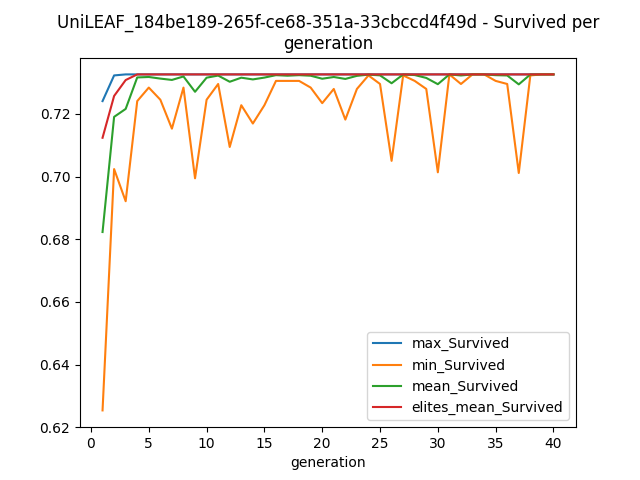

In [29]:
plot_file = os.path.join(experiment_results_dir, 'Survived_plot.png')
Image(filename=plot_file)

# Models usage
## Load the Prescriptor

In [30]:
# Use the last row of the stats DataFrame, i.e. the last generation, to find the best model
last_gen = stats_df['generation'].iloc[-1]
best_score = stats_df['max_Survived'].iloc[-1]
cid_best_score = stats_df['cid_max_Survived'].iloc[-1]
prescriptor_model_filename = os.path.join(experiment_results_dir,
                                          str(last_gen),
                                          cid_best_score + '.h5')
print(f'Best max_Survived average is {best_score:.3f} for candidate id {cid_best_score}')

Best max_Survived average is 0.733 for candidate id 3_7


In [31]:
from keras.models import load_model

print(f'Loading prescriptor model: {prescriptor_model_filename}')
prescriptor_model = load_model(prescriptor_model_filename, compile=False)

Loading prescriptor model: trained_prescriptors/UniLEAF_184be189-265f-ce68-351a-33cbccd4f49d/1.0.0_20251027-131022/40/3_7.h5


## Get a sample context
Get the context from one of the rows in the dataset, and make a prescription for it.

In [32]:
sample_df = data_source_df.sample(1)
sample_context_df = sample_df[CONTEXT_COLUMNS]
sample_context_action_df = sample_df[CONTEXT_ACTION_COLUMNS]
sample_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
141,699,0.0,1,"Thayer, Mr. John Borland",male,49.0,1,1,17421,110.8833,C68,C


### Prescribe


In [33]:
encoded_sample_context_df = encoder.encode_as_df(sample_context_df)
encoded_prescribed_actions_df = esp_evaluator.prescribe(prescriptor_model, encoded_sample_context_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [34]:
# Aggregate the context and actions dataframes.
encoded_context_actions_df = pd.concat([encoded_sample_context_df,
                                        encoded_prescribed_actions_df],
                                       axis=1)
sample_context_prescribed_action_df = encoder.decode_as_df(encoded_context_actions_df)
sample_context_prescribed_action_df

,Age,Sex,Fare,Pclass,Parch,SibSp,Cabin_n,Cabin_r,Embarked
0,49.0,male,110.8833,1,2,1,3,F,C


### Make predictions


In [35]:
def get_predictions(predictors, context_action_df, encoder):
    pred_array = []
    for predictor in predictors:
        pred = predictor.predict(encoder.encode_as_df(context_action_df))
        pred_array.append(encoder.decode_as_df(pred))
    preds_df = pd.concat(pred_array, axis=1)
    return preds_df

#### With original actions

In [36]:
original_actions_preds = get_predictions(all_predictors, sample_context_action_df, encoder)
original_actions_preds

,Survived
0,0.37


#### With prescribed actions

In [37]:
prescribed_actions_preds = get_predictions(all_predictors, sample_context_prescribed_action_df, encoder)
prescribed_actions_preds

,Survived
0,0.37


#### With custom actions

In [38]:
sample_context_custom_action_df = sample_context_prescribed_action_df.copy()
 # TODO: Uncomment and replace by the name of the actions(s) to customize
# sample_context_custom_action_df['SOME_ACTION_TO_CUSTOMIZE'] = 42
sample_context_custom_action_df

,Age,Sex,Fare,Pclass,Parch,SibSp,Cabin_n,Cabin_r,Embarked
0,49.0,male,110.8833,1,2,1,3,F,C


In [39]:
custom_actions_preds = get_predictions(all_predictors, sample_context_custom_action_df, encoder)
custom_actions_preds

,Survived
0,0.37


### Compare

In [40]:
OUTCOME_COLUMNS = list(original_actions_preds.columns)
OUTCOME_COLUMNS

['Survived']

In [41]:
# Observed OUTCOMES for the sample
pd.DataFrame(sample_df[OUTCOME_COLUMNS])

,Survived
141,0.0


In [42]:
comp_df = pd.concat([sample_context_action_df,
                     sample_context_prescribed_action_df,
                     sample_context_custom_action_df], axis=0)
# Observed OUTCOMES
comp_df[OUTCOME_COLUMNS] = sample_df[OUTCOME_COLUMNS].iloc[0]
# Predicted OUTCOMES
preds_data = {}
for outcome_column in OUTCOME_COLUMNS:
    preds_data[f'{outcome_column}_predicted'] = [original_actions_preds[outcome_column].iloc[0],
                                                 prescribed_actions_preds[outcome_column].iloc[0],
                                                 custom_actions_preds[outcome_column].iloc[0]]
preds_df = pd.DataFrame(preds_data)
comp_df[list(preds_data.keys())] = preds_df[list(preds_data.keys())].values
# Diff
for outcome_column in OUTCOME_COLUMNS:
    if is_numeric_dtype(comp_df[outcome_column]):
        comp_df[f'{outcome_column}_diff'] = comp_df[f'{outcome_column}_predicted'] - comp_df[outcome_column]
comp_df


/var/folders/sq/wczx8z_50yn5szt1q9b333fr0000gp/T/ipykernel_48155/2356294836.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  comp_df[OUTCOME_COLUMNS] = sample_df[OUTCOME_COLUMNS].iloc[0]


,Age,Sex,Fare,Pclass,Parch,SibSp,Embarked,Cabin_n,Cabin_r,Survived,Survived_predicted,Survived_diff
141,49.0,male,110.8833,1,1,1,C,NaN,NaN,0.0,0.37,0.37
0,49.0,male,110.8833,1,2,1,C,3.0,F,0.0,0.37,0.37
0,49.0,male,110.8833,1,2,1,C,3.0,F,0.0,0.37,0.37
